# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -2 * np.ones((dim_full, 1))
ub = 2 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

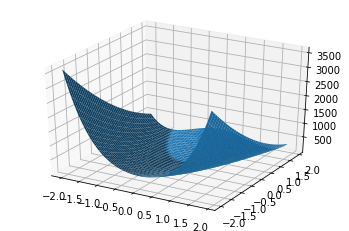

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()
n_starts = 20

result1 = pypesto.minimize(problem=problem1, optimizer=optimizer, n_starts=n_starts)
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer, n_starts=n_starts)

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [5]:

result1 = pypesto.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=1)

## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

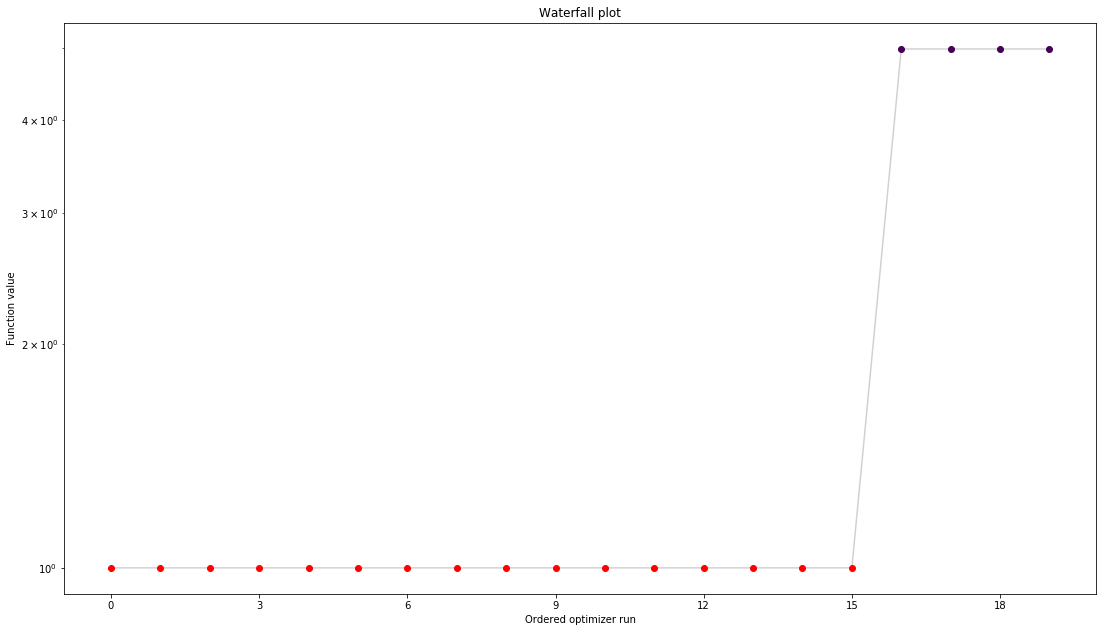

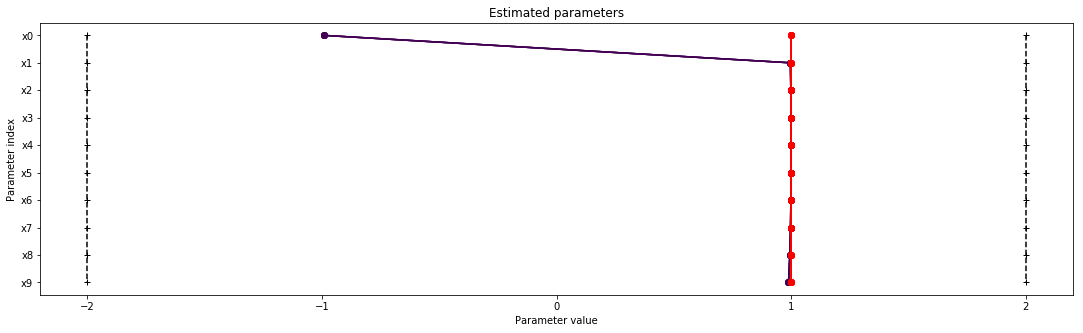

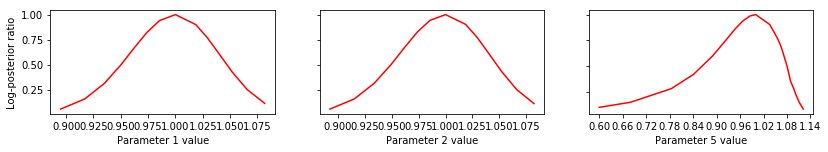

In [6]:
import pypesto.visualize

pypesto.visualize.waterfall(result1)
pypesto.visualize.parameters(result1)

# specify the parameters, for which profiles should be computed
pypesto.visualize.profiles(result1, profile_indices = [1,2,5])

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [7]:
result1.optimize_result.as_dataframe(['fval', 'n_fval', 'n_grad', 'n_hess', 'n_res', 'n_sres', 'time'])

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,3.864669e-12,89,89,0,0,0,0.016705
1,5.391376e-12,83,83,0,0,0,0.015477
2,6.878944e-12,88,88,0,0,0,0.119707
3,7.215911e-12,91,91,0,0,0,0.037070
4,9.545020e-12,69,69,0,0,0,0.022376
5,1.244748e-11,83,83,0,0,0,0.022337
6,1.263889e-11,88,88,0,0,0,0.018748
7,1.562623e-11,86,86,0,0,0,0.022854
8,4.085166e-11,73,73,0,0,0,0.011622
9,7.246517e-11,79,79,0,0,0,0.026188
